Berceley Deep RL course. Fall 2017
http://rll.berkeley.edu/deeprlcourse/
Homework 1

## Behavioral Cloning
1.  Run  behavioral  cloning  (BC)  and  report  results  on  two  other  tasks  –  one  task  where  a  behavioral
cloning agent achieves comparable performance to the expert, and one task where it does not.  When
providing  results,  report  the  mean  and  standard  deviation  of  the  return  over  multiple  rollouts  in  a
table, and state which task was used.  Be sure to set up a fair comparison, in terms of network size,
amount of data, and number of training iterations, and provide these details (and any others you feel
are appropriate) in the table caption.
1
2.  Experiment with one hyperparameter that affects the performance of the behavioral cloning agent, such
as the number of demonstrations, the number of training epochs, the variance of the expert policy, or
something that you come up with yourself.  For one of the tasks used in the previous question, show a
graph of how the BC agent’s performance varies with the value of this hyperparameter, and state the
hyperparameter and a brief rationale for why you chose it in the caption for the graph.

In [2]:
import gym
 
env = gym.make('Hopper-v1')

[2017-11-02 13:36:29,209] Making new env: Hopper-v1


In [3]:
import time
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### Feed forward nn

In [4]:
class FFN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,output_size,dropout_rate = 0.3):
        super(FFN, self).__init__()
        self.dropout_rate = dropout_rate
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.drop1  = nn.Dropout(p = self.dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.drop2  = nn.Dropout(p = self.dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x.view(x.size(0), -1)
    
    def set_dropout_rate(self, p):
        self.dropout_rate = p
        


In [5]:
criterion = torch.nn.L1Loss()

# Training function
def train_ffn(states_tensor, actions_tensor,learning_rate):
    tmp_loss = 0
    
    ffn.zero_grad()

    output = ffn(states_tensor)               # Predict action
    loss = criterion(output, actions_tensor)  # Calculate error
    tmp_loss += loss.data[0]
    loss.backward()                              # Error backpropagation

    for p in ffn.parameters():                   # Update net's parameters
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, tmp_loss 

In [6]:
#!/usr/bin/env python

"""
Code to load an expert policy and generate roll-out data for behavioral cloning.
Example usage:
    python run_expert.py experts/Humanoid-v1.pkl Humanoid-v1 --render \
            --num_rollouts 20

Author of this script and included expert policies: Jonathan Ho (hoj@openai.com)
"""

import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import pandas as pd

minibatch_size = 8

def learn_imitatation_learning(ffn, args):
    
    print('loading and building expert policy')
    target_policy_fn = load_policy.load_policy(args.expert_policy_file)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()

        import gym
        env = gym.make(args.envname)
        max_steps = args.max_timesteps or env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(args.num_rollouts):
            #print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = target_policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                
                if args.render:
                    env.render()
                if steps % minibatch_size == 0: 
                    _, error = train_ffn(Variable(torch.Tensor(observations[-minibatch_size:])), 
                                         Variable(torch.Tensor(np.array(actions[-minibatch_size:])[:,0,:])),
                                         learning_rate
                                        )
                    #print("%i/%i, Error %f"%(steps, max_steps,error))
                    
                    
                if steps >= max_steps:
                    break
            returns.append(totalr)

#         print('returns', returns)
#         print('mean return', np.mean(returns))
#         print('std of return', np.std(returns))

#         expert_data = {'observations': np.array(observations),
#                        'actions': np.array(actions)}
        return returns,error
        

#Evaluate learned policy
def evaluate_imitation_learning(ffn, args):
    dropout_rate = ffn.dropout_rate
    ffn.dropout_rate = 0
    env = gym.make(args.envname)
    max_steps = args.max_timesteps or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(args.num_rollouts):
        #print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = ffn(Variable(torch.Tensor(obs))).data.numpy()  
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1

            if args.render:
                env.render()

            if steps >= max_steps:
                break
            
        #print(totalr)
        returns.append(totalr)

#     print('returns', returns)
#     print('mean return', np.mean(returns))
#     print('std of return', np.std(returns))

#     expert_data = {'observations': np.array(observations),
#                    'actions': np.array(actions)}
        ffn.dropout_rate = dropout_rate
        return returns


In [7]:
! ls experts/

Ant-v1.pkl	    Hopper-v1.pkl    Reacher-v1.pkl
HalfCheetah-v1.pkl  Humanoid-v1.pkl  Walker2d-v1.pkl


### Train loop

In [9]:
learning_rate = 1e-2

envname = 'Reacher-v1'
env = gym.make(envname)
#with gym.make(envname) as env:
state_shape = env.observation_space.shape[0]
actions_shape = env.action_space.shape[0]

print('Starting {} environment. State space dim (), action space dim {}.'.format(
    envname,
    state_shape,
    actions_shape)
     )

ffn = FFN(state_shape, 128, 64,actions_shape,dropout_rate = 0)

learn_args = pd.Series({
        'expert_policy_file':'experts/' + envname + '.pkl',
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':2,
        'render': False
    })


eval_args = pd.Series({
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':2,
        'render': False
    })

n_iter = 300

results = []
for i in range(n_iter):
    experts_returns, error = learn_imitatation_learning(ffn, learn_args)
    agent_returns   = evaluate_imitation_learning(ffn, eval_args)
    print(i, np.mean(experts_returns),np.mean(error), np.mean(agent_returns),np.std(agent_returns))
    results.append((np.mean(experts_returns),np.mean(error),np.mean(agent_returns),np.std(agent_returns)))


[2017-11-02 13:38:30,432] Making new env: Reacher-v1


Starting Reacher-v1 environment. State space dim (), action space dim 11.
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:30,812] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:30,817] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:30,851] Making new env: Reacher-v1
[2017-11-02 13:38:31,747] Making new env: Reacher-v1


0 -4.48011896978 0.0249968785793 -18.5133287639 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:32,134] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:32,150] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:32,186] Making new env: Reacher-v1
[2017-11-02 13:38:32,920] Making new env: Reacher-v1


1 -3.21461490516 0.0217208806425 -5.06671066177 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:33,310] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:33,330] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:33,366] Making new env: Reacher-v1
[2017-11-02 13:38:34,105] Making new env: Reacher-v1


2 -2.63695381251 0.0224887076765 -10.0118595213 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:34,522] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:34,535] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:34,573] Making new env: Reacher-v1
[2017-11-02 13:38:35,355] Making new env: Reacher-v1


3 -4.54432138268 0.0294921509922 -10.3962612469 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:35,724] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:35,736] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:35,775] Making new env: Reacher-v1
[2017-11-02 13:38:36,372] Making new env: Reacher-v1


4 -6.72867985701 0.0194030236453 -20.0519891395 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:36,558] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:36,571] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:36,606] Making new env: Reacher-v1
[2017-11-02 13:38:37,184] Making new env: Reacher-v1


5 -4.64525372776 0.00662121968344 -12.1373982829 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:37,463] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:37,484] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:37,512] Making new env: Reacher-v1
[2017-11-02 13:38:37,940] Making new env: Reacher-v1


6 -4.87642466747 0.0154308006167 -10.5268786632 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:38,277] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:38,298] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:38,346] Making new env: Reacher-v1
[2017-11-02 13:38:39,003] Making new env: Reacher-v1


7 -5.16689814773 0.00726638687775 -10.8115030801 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:39,338] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:39,358] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:39,418] Making new env: Reacher-v1
[2017-11-02 13:38:40,184] Making new env: Reacher-v1


8 -4.60047386804 0.0348354279995 -9.37485245647 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:40,558] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:40,571] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:40,613] Making new env: Reacher-v1
[2017-11-02 13:38:41,056] Making new env: Reacher-v1


9 -4.73462636131 0.0165550559759 -11.1195926359 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:41,390] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:41,403] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:41,458] Making new env: Reacher-v1
[2017-11-02 13:38:41,806] Making new env: Reacher-v1


10 -3.62058422267 0.00594569183886 -12.2562914997 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:42,046] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:42,058] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:42,103] Making new env: Reacher-v1
[2017-11-02 13:38:42,603] Making new env: Reacher-v1


11 -7.1670529618 0.0294744297862 -8.76727604365 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:42,814] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:42,827] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:42,868] Making new env: Reacher-v1
[2017-11-02 13:38:43,216] Making new env: Reacher-v1


12 -4.65776924288 0.011467714794 -6.65035344961 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:43,373] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:43,385] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:43,421] Making new env: Reacher-v1
[2017-11-02 13:38:43,979] Making new env: Reacher-v1


13 -3.88238470803 0.0246757399291 -12.5301913175 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:44,377] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:44,399] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:44,475] Making new env: Reacher-v1
[2017-11-02 13:38:45,147] Making new env: Reacher-v1


14 -4.14437403895 0.015617785044 -19.4526986555 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:45,561] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:45,573] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:45,654] Making new env: Reacher-v1
[2017-11-02 13:38:46,397] Making new env: Reacher-v1


15 -3.66708480106 0.00998050812632 -16.4613742553 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:46,904] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:46,923] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:47,030] Making new env: Reacher-v1
[2017-11-02 13:38:47,967] Making new env: Reacher-v1


16 -3.90837859696 0.00835358258337 -16.0653468649 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:48,438] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:48,449] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:48,561] Making new env: Reacher-v1
[2017-11-02 13:38:49,386] Making new env: Reacher-v1


17 -4.1830876427 0.00856664590538 -21.2276583397 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:49,859] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:49,877] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:49,978] Making new env: Reacher-v1
[2017-11-02 13:38:50,871] Making new env: Reacher-v1


18 -3.8219560842 0.00992315728217 -14.4437805919 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:51,259] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:51,283] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:51,385] Making new env: Reacher-v1
[2017-11-02 13:38:51,939] Making new env: Reacher-v1


19 -3.58197863415 0.00375195359811 -7.20100606118 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:52,299] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:52,317] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:52,415] Making new env: Reacher-v1
[2017-11-02 13:38:53,308] Making new env: Reacher-v1


20 -3.30398744498 0.00858650542796 -11.3141399307 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:53,579] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:53,597] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:53,670] Making new env: Reacher-v1
[2017-11-02 13:38:54,269] Making new env: Reacher-v1


21 -3.87700634795 0.0227475594729 -7.79157542556 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:54,836] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:54,858] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:54,988] Making new env: Reacher-v1
[2017-11-02 13:38:55,870] Making new env: Reacher-v1


22 -3.81012042262 0.0183057039976 -20.0282854278 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:56,203] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:56,235] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:56,379] Making new env: Reacher-v1
[2017-11-02 13:38:57,269] Making new env: Reacher-v1


23 -3.97150847583 0.0163406152278 -2.54021974677 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:57,842] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:57,873] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:58,027] Making new env: Reacher-v1
[2017-11-02 13:38:58,736] Making new env: Reacher-v1


24 -3.3623367105 0.0171048715711 -9.85047260337 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:59,298] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:59,320] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:59,472] Making new env: Reacher-v1
[2017-11-02 13:39:00,395] Making new env: Reacher-v1


25 -4.60411483737 0.00775867886841 -7.98905986665 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:00,861] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:00,885] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:01,053] Making new env: Reacher-v1
[2017-11-02 13:39:01,960] Making new env: Reacher-v1


26 -6.06918314383 0.022565420717 -18.609792516 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:02,403] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:02,425] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:02,568] Making new env: Reacher-v1
[2017-11-02 13:39:03,501] Making new env: Reacher-v1


27 -4.06655140162 0.0157926734537 -13.9987718186 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:03,826] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:03,846] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:03,953] Making new env: Reacher-v1
[2017-11-02 13:39:04,419] Making new env: Reacher-v1


28 -4.28433863715 0.0182299800217 -18.5094485699 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:04,735] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:04,755] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:04,930] Making new env: Reacher-v1
[2017-11-02 13:39:05,807] Making new env: Reacher-v1


29 -4.68415496917 0.0111899487674 -16.5713631989 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:06,316] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:06,340] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:06,482] Making new env: Reacher-v1
[2017-11-02 13:39:07,191] Making new env: Reacher-v1


30 -3.30535898987 0.0233104098588 -17.8322906201 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:07,450] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:07,466] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:07,650] Making new env: Reacher-v1
[2017-11-02 13:39:08,448] Making new env: Reacher-v1


31 -3.31193577273 0.017198484391 -8.68305565174 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:08,890] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:08,907] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:09,048] Making new env: Reacher-v1
[2017-11-02 13:39:09,781] Making new env: Reacher-v1


32 -3.90023910164 0.0103233363479 -17.6274582265 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:10,145] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:10,160] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:10,369] Making new env: Reacher-v1
[2017-11-02 13:39:11,200] Making new env: Reacher-v1


33 -5.56889777185 0.00789389293641 -8.44563666281 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:11,686] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:11,701] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:11,918] Making new env: Reacher-v1
[2017-11-02 13:39:12,628] Making new env: Reacher-v1


34 -6.49853365617 0.0114648146555 -19.831457657 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:13,079] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:13,097] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:13,315] Making new env: Reacher-v1
[2017-11-02 13:39:14,187] Making new env: Reacher-v1


35 -3.36174396151 0.00868783146143 -5.31244945434 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:14,579] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:14,597] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:14,706] Making new env: Reacher-v1
[2017-11-02 13:39:15,401] Making new env: Reacher-v1


36 -4.41141016243 0.00512833893299 -15.1906634676 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:15,809] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:15,827] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:16,007] Making new env: Reacher-v1
[2017-11-02 13:39:16,933] Making new env: Reacher-v1


37 -4.79191078812 0.0170635413378 -2.72818317936 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:17,390] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:17,412] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:17,639] Making new env: Reacher-v1
[2017-11-02 13:39:18,615] Making new env: Reacher-v1


38 -3.50312881753 0.00689481245354 -16.333679704 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:19,010] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:19,024] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:19,278] Making new env: Reacher-v1
[2017-11-02 13:39:20,237] Making new env: Reacher-v1


39 -3.96412609832 0.0145634422079 -10.3470561409 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:20,666] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:20,689] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:20,865] Making new env: Reacher-v1
[2017-11-02 13:39:22,060] Making new env: Reacher-v1


40 -5.28540432108 0.00702193100005 -16.5997279555 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:22,630] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:22,663] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:22,920] Making new env: Reacher-v1
[2017-11-02 13:39:23,888] Making new env: Reacher-v1


41 -5.0149544641 0.0118332868442 -5.02467981796 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:24,461] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:24,490] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:24,771] Making new env: Reacher-v1
[2017-11-02 13:39:25,794] Making new env: Reacher-v1


42 -4.05308700852 0.00443720631301 -21.7466163774 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:26,343] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:26,360] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:26,615] Making new env: Reacher-v1
[2017-11-02 13:39:27,616] Making new env: Reacher-v1


43 -3.09622262503 0.00842527486384 -5.02265857722 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:28,055] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:28,071] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:28,280] Making new env: Reacher-v1
[2017-11-02 13:39:28,959] Making new env: Reacher-v1


44 -3.10681261176 0.00877940561622 -7.83047997532 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:29,326] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:29,350] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:29,582] Making new env: Reacher-v1
[2017-11-02 13:39:30,471] Making new env: Reacher-v1


45 -5.51105712242 0.00322679569945 -19.6417894824 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:30,971] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:30,994] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:31,229] Making new env: Reacher-v1
[2017-11-02 13:39:31,817] Making new env: Reacher-v1


46 -1.93078144456 0.0159616041929 -17.124779701 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:32,183] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:32,203] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:32,389] Making new env: Reacher-v1
[2017-11-02 13:39:33,183] Making new env: Reacher-v1


47 -3.14725253285 0.00421625701711 -14.2608915805 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:33,543] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:33,565] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:33,796] Making new env: Reacher-v1
[2017-11-02 13:39:34,972] Making new env: Reacher-v1


48 -3.10939815059 0.0169025417417 -14.5235310008 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:35,543] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:35,569] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:35,876] Making new env: Reacher-v1
[2017-11-02 13:39:36,948] Making new env: Reacher-v1


49 -6.57190857707 0.00578370410949 -4.44685403899 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:38,100] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:38,138] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:38,458] Making new env: Reacher-v1
[2017-11-02 13:39:39,586] Making new env: Reacher-v1


50 -4.97441615148 0.00679482333362 -11.1316796556 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:40,141] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:40,173] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:40,553] Making new env: Reacher-v1
[2017-11-02 13:39:41,746] Making new env: Reacher-v1


51 -3.30621286101 0.0133803421631 -8.9577207656 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:42,373] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:42,391] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:42,750] Making new env: Reacher-v1
[2017-11-02 13:39:43,921] Making new env: Reacher-v1


52 -3.62691485455 0.00416935794055 -12.7625103253 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:44,566] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:44,580] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:44,925] Making new env: Reacher-v1
[2017-11-02 13:39:46,059] Making new env: Reacher-v1


53 -4.44838946241 0.00862791296095 -20.8686618695 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:46,671] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:46,694] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:47,039] Making new env: Reacher-v1
[2017-11-02 13:39:48,177] Making new env: Reacher-v1


54 -2.74239170207 0.00215899804607 -8.31560636459 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:48,759] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:48,789] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:49,143] Making new env: Reacher-v1
[2017-11-02 13:39:50,200] Making new env: Reacher-v1


55 -4.690782841 0.0116273732856 -3.41010205821 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:50,668] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:50,690] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:50,995] Making new env: Reacher-v1
[2017-11-02 13:39:51,839] Making new env: Reacher-v1


56 -3.53139907428 0.00472050486133 -9.09823019052 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:52,374] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:52,399] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:52,683] Making new env: Reacher-v1
[2017-11-02 13:39:53,476] Making new env: Reacher-v1


57 -1.20820947153 0.00375355081633 -17.2364741673 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:53,915] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:53,935] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:54,260] Making new env: Reacher-v1
[2017-11-02 13:39:55,293] Making new env: Reacher-v1


58 -5.94117281476 0.0054051829502 -16.6394930949 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:55,811] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:55,831] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:56,144] Making new env: Reacher-v1
[2017-11-02 13:39:57,124] Making new env: Reacher-v1


59 -5.43734612897 0.0174589138478 -4.16282789119 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:57,588] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:57,603] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:57,914] Making new env: Reacher-v1
[2017-11-02 13:39:58,792] Making new env: Reacher-v1


60 -4.20042354608 0.00802415236831 -8.51859288627 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:59,315] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:59,338] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:59,640] Making new env: Reacher-v1
[2017-11-02 13:40:00,733] Making new env: Reacher-v1


61 -3.72576722682 0.00716607552022 -7.58440314414 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:01,338] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:01,374] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:01,753] Making new env: Reacher-v1
[2017-11-02 13:40:03,008] Making new env: Reacher-v1


62 -3.86159827459 0.0105558671057 -12.5325103211 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:03,589] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:03,610] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:04,107] Making new env: Reacher-v1
[2017-11-02 13:40:05,464] Making new env: Reacher-v1


63 -3.35496780549 0.0109641645104 -6.43095737321 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:06,254] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:06,277] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:06,708] Making new env: Reacher-v1
[2017-11-02 13:40:07,922] Making new env: Reacher-v1


64 -4.07661811708 0.00965235568583 -10.5738842824 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:08,554] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:08,579] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:09,038] Making new env: Reacher-v1
[2017-11-02 13:40:10,240] Making new env: Reacher-v1


65 -5.12989389195 0.00822968222201 -11.5243468786 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:10,701] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:10,719] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:11,073] Making new env: Reacher-v1
[2017-11-02 13:40:12,128] Making new env: Reacher-v1


66 -3.38795678003 0.0134785845876 -5.01565649846 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:12,681] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:12,700] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:13,035] Making new env: Reacher-v1
[2017-11-02 13:40:14,011] Making new env: Reacher-v1


67 -2.13119177222 0.0112077575177 -13.9992580652 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:14,522] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:14,551] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:14,954] Making new env: Reacher-v1
[2017-11-02 13:40:16,053] Making new env: Reacher-v1


68 -3.93236721668 0.0146325547248 -8.88270457686 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:16,591] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:16,615] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:16,996] Making new env: Reacher-v1
[2017-11-02 13:40:18,103] Making new env: Reacher-v1


69 -5.33916485905 0.0108311772346 -14.9002856513 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:18,668] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:18,695] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:19,105] Making new env: Reacher-v1
[2017-11-02 13:40:20,088] Making new env: Reacher-v1


70 -4.94498692025 0.0103177968413 -13.9851459701 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:20,551] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:20,572] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:20,983] Making new env: Reacher-v1
[2017-11-02 13:40:22,174] Making new env: Reacher-v1


71 -2.68353322127 0.00912592094392 -5.13271786503 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:22,726] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:22,752] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:23,165] Making new env: Reacher-v1
[2017-11-02 13:40:24,121] Making new env: Reacher-v1


72 -3.18009197594 0.00745691964403 -4.39121487095 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:24,621] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:24,638] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:25,086] Making new env: Reacher-v1
[2017-11-02 13:40:26,238] Making new env: Reacher-v1


73 -2.23839229474 0.010993167758 -8.06997763888 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:26,793] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:26,815] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:27,283] Making new env: Reacher-v1
[2017-11-02 13:40:28,155] Making new env: Reacher-v1


74 -3.51671662006 0.0292618293315 -18.1422906279 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:28,602] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:28,621] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:28,991] Making new env: Reacher-v1
[2017-11-02 13:40:29,875] Making new env: Reacher-v1


75 -2.46106569364 0.00935944635421 -16.1568472422 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:30,320] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:30,342] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:30,803] Making new env: Reacher-v1
[2017-11-02 13:40:32,198] Making new env: Reacher-v1


76 -6.23234913389 0.0087119275704 -9.20978593248 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:32,644] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:32,664] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:33,033] Making new env: Reacher-v1
[2017-11-02 13:40:33,838] Making new env: Reacher-v1


77 -3.63370736307 0.0047644386068 -18.2843589993 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:34,267] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:34,289] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:34,665] Making new env: Reacher-v1
[2017-11-02 13:40:35,489] Making new env: Reacher-v1


78 -4.98678736035 0.00960585940629 -12.5920648005 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:35,922] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:35,942] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:36,322] Making new env: Reacher-v1
[2017-11-02 13:40:37,128] Making new env: Reacher-v1


79 -5.28961308727 0.00590438442305 -17.3610253602 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:37,555] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:37,580] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:37,956] Making new env: Reacher-v1
[2017-11-02 13:40:38,783] Making new env: Reacher-v1


80 -4.13914596128 0.0129917692393 -14.8056730952 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:39,308] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:39,331] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:39,739] Making new env: Reacher-v1
[2017-11-02 13:40:40,529] Making new env: Reacher-v1


81 -4.80568263349 0.00562906498089 -18.9738560246 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:40,942] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:40,964] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:41,355] Making new env: Reacher-v1
[2017-11-02 13:40:42,137] Making new env: Reacher-v1


82 -2.7456598226 0.0125185847282 -4.378658969 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:42,606] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:42,634] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:43,031] Making new env: Reacher-v1
[2017-11-02 13:40:45,465] Making new env: Reacher-v1


83 -4.7329464385 0.00853740703315 -21.4265539556 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:46,072] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:46,104] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:46,674] Making new env: Reacher-v1
[2017-11-02 13:40:47,694] Making new env: Reacher-v1


84 -3.32207265241 0.00520444568247 -8.47515965262 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:48,169] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:48,187] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:48,686] Making new env: Reacher-v1
[2017-11-02 13:40:49,419] Making new env: Reacher-v1


85 -3.9899105303 0.0234218277037 -15.3994618964 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:49,741] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:49,766] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:50,085] Making new env: Reacher-v1
[2017-11-02 13:40:50,713] Making new env: Reacher-v1


86 -3.20281267855 0.0127684995532 -17.1249562377 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:51,099] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:51,124] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:51,525] Making new env: Reacher-v1
[2017-11-02 13:40:52,349] Making new env: Reacher-v1


87 -2.92525751978 0.00870651938021 -10.7951214575 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:52,736] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:52,754] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:53,116] Making new env: Reacher-v1
[2017-11-02 13:40:53,755] Making new env: Reacher-v1


88 -3.47671636692 0.00324764498509 -9.84748321079 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:54,168] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:54,190] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:54,550] Making new env: Reacher-v1
[2017-11-02 13:40:55,193] Making new env: Reacher-v1


89 -3.12089554825 0.0103494729847 -7.21102700277 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:55,533] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:55,554] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:55,897] Making new env: Reacher-v1
[2017-11-02 13:40:56,519] Making new env: Reacher-v1


90 -2.74821744553 0.00383963086642 -11.7765963602 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:56,844] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:56,865] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:57,215] Making new env: Reacher-v1
[2017-11-02 13:40:57,808] Making new env: Reacher-v1


91 -4.6974572135 0.0110600786284 -13.2550080754 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:58,135] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:58,161] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:58,511] Making new env: Reacher-v1
[2017-11-02 13:40:59,140] Making new env: Reacher-v1


92 -2.77717161677 0.0108879953623 -18.3215543271 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:59,536] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:59,556] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:59,920] Making new env: Reacher-v1
[2017-11-02 13:41:00,646] Making new env: Reacher-v1


93 -3.77524012314 0.0139842694625 -14.4596883312 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:00,978] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:01,001] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:01,375] Making new env: Reacher-v1
[2017-11-02 13:41:02,036] Making new env: Reacher-v1


94 -3.57242768919 0.00182374892756 -8.57689854938 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:02,434] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:02,454] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:02,825] Making new env: Reacher-v1
[2017-11-02 13:41:03,445] Making new env: Reacher-v1


95 -4.6289351181 0.00439253123477 -12.7977854332 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:03,796] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:03,818] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:04,182] Making new env: Reacher-v1
[2017-11-02 13:41:04,802] Making new env: Reacher-v1


96 -3.63254113107 0.00533297192305 -8.67933257968 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:05,139] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:05,163] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:05,539] Making new env: Reacher-v1
[2017-11-02 13:41:06,195] Making new env: Reacher-v1


97 -3.89395311745 0.000683797174133 -13.8698312973 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:06,542] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:06,563] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:06,938] Making new env: Reacher-v1
[2017-11-02 13:41:07,562] Making new env: Reacher-v1


98 -5.88787587023 0.00871679931879 -11.7059333368 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:07,894] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:07,913] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:08,306] Making new env: Reacher-v1
[2017-11-02 13:41:08,927] Making new env: Reacher-v1


99 -4.08868907136 0.0136275123805 -2.6363811018 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:09,439] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:09,450] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:09,902] Making new env: Reacher-v1
[2017-11-02 13:41:10,543] Making new env: Reacher-v1


100 -2.78889446516 0.00669482536614 -3.11813969598 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:10,887] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:10,904] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:11,491] Making new env: Reacher-v1
[2017-11-02 13:41:12,237] Making new env: Reacher-v1


101 -2.62020890285 0.00451274355873 -7.35382714568 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:12,645] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:12,654] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:13,175] Making new env: Reacher-v1
[2017-11-02 13:41:14,112] Making new env: Reacher-v1


102 -3.49093426089 0.00304724834859 -6.32962046771 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:14,538] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:14,559] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:14,964] Making new env: Reacher-v1
[2017-11-02 13:41:15,583] Making new env: Reacher-v1


103 -3.01756360248 0.00898823607713 -10.1022539944 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:15,940] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:15,958] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:16,362] Making new env: Reacher-v1
[2017-11-02 13:41:17,005] Making new env: Reacher-v1


104 -6.63552442724 0.0162877645344 -9.61612476292 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:17,334] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:17,353] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:17,763] Making new env: Reacher-v1
[2017-11-02 13:41:18,373] Making new env: Reacher-v1


105 -7.03471612127 0.00896046496928 -14.6599507742 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:18,714] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:18,734] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:19,174] Making new env: Reacher-v1
[2017-11-02 13:41:19,819] Making new env: Reacher-v1


106 -3.48445339094 0.00860723108053 -15.9459777252 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:20,150] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:20,168] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:20,596] Making new env: Reacher-v1
[2017-11-02 13:41:21,281] Making new env: Reacher-v1


107 -2.20140230257 0.00414805533364 -10.4366328238 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:21,626] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:21,645] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:22,075] Making new env: Reacher-v1
[2017-11-02 13:41:22,723] Making new env: Reacher-v1


108 -4.91778547074 0.00828186608851 -8.05828614592 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:23,069] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:23,091] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:23,556] Making new env: Reacher-v1
[2017-11-02 13:41:24,207] Making new env: Reacher-v1


109 -3.86129734331 0.0099603543058 -17.218201735 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:24,546] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:24,570] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:24,972] Making new env: Reacher-v1
[2017-11-02 13:41:25,624] Making new env: Reacher-v1


110 -4.15103495552 0.0112254833803 -20.6578220708 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:25,942] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:25,962] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:26,369] Making new env: Reacher-v1
[2017-11-02 13:41:27,045] Making new env: Reacher-v1


111 -2.1687836469 0.00237247068435 -11.629629284 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:27,483] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:27,504] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:28,002] Making new env: Reacher-v1
[2017-11-02 13:41:28,639] Making new env: Reacher-v1


112 -4.52694553378 0.00982469227165 -16.1699593234 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:28,978] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:28,996] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:29,462] Making new env: Reacher-v1
[2017-11-02 13:41:30,135] Making new env: Reacher-v1


113 -2.38043756171 0.00903414282948 -7.00301916562 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:30,473] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:30,492] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:30,911] Making new env: Reacher-v1
[2017-11-02 13:41:31,569] Making new env: Reacher-v1


114 -0.947596331354 0.00321923010051 -11.9947490804 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:31,910] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:31,932] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:32,362] Making new env: Reacher-v1
[2017-11-02 13:41:33,055] Making new env: Reacher-v1


115 -3.61274977303 0.00720474310219 -10.2903323904 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:33,395] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:33,416] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:33,866] Making new env: Reacher-v1
[2017-11-02 13:41:34,509] Making new env: Reacher-v1


116 -4.76790898169 0.00602850317955 -8.01728052192 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:34,853] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:34,874] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:35,322] Making new env: Reacher-v1
[2017-11-02 13:41:35,971] Making new env: Reacher-v1


117 -2.12259260616 0.00508188456297 -18.7756604952 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:36,326] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:36,350] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:36,808] Making new env: Reacher-v1
[2017-11-02 13:41:37,449] Making new env: Reacher-v1


118 -6.05093548814 0.00744640640914 -15.7723869466 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:37,795] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:37,813] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:38,250] Making new env: Reacher-v1
[2017-11-02 13:41:38,883] Making new env: Reacher-v1


119 -3.96675321473 0.000712747627404 -11.5526062183 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:39,220] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:39,241] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:39,730] Making new env: Reacher-v1
[2017-11-02 13:41:40,442] Making new env: Reacher-v1


120 -1.76465995464 0.0111645888537 -1.91069092308 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:40,777] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:40,799] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:41,255] Making new env: Reacher-v1
[2017-11-02 13:41:41,871] Making new env: Reacher-v1


121 -5.2085323315 0.00804163794965 -18.1961350699 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:42,545] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:42,565] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:43,043] Making new env: Reacher-v1
[2017-11-02 13:41:43,676] Making new env: Reacher-v1


122 -3.93394199998 0.0132401008159 -12.1856979224 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:44,011] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:44,032] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:44,517] Making new env: Reacher-v1
[2017-11-02 13:41:45,140] Making new env: Reacher-v1


123 -4.14690511262 0.017548955977 -14.8238878109 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:45,478] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:45,505] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:45,968] Making new env: Reacher-v1
[2017-11-02 13:41:46,600] Making new env: Reacher-v1


124 -2.49956910842 0.00466239452362 -19.1593300516 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:46,934] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:46,955] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:47,442] Making new env: Reacher-v1
[2017-11-02 13:41:48,078] Making new env: Reacher-v1


125 -6.9267301231 0.00774322450161 -8.74436452814 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:48,420] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:48,436] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:48,909] Making new env: Reacher-v1
[2017-11-02 13:41:49,542] Making new env: Reacher-v1


126 -5.57992437243 0.0085748527199 -20.6570672303 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:49,871] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:49,887] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:50,362] Making new env: Reacher-v1
[2017-11-02 13:41:50,973] Making new env: Reacher-v1


127 -4.57486718288 0.00840381346643 -13.4938551912 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:51,331] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:51,357] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:51,866] Making new env: Reacher-v1
[2017-11-02 13:41:52,482] Making new env: Reacher-v1


128 -3.53346712589 0.0113370893523 -10.2397881471 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:52,856] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:52,873] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:53,395] Making new env: Reacher-v1
[2017-11-02 13:41:54,010] Making new env: Reacher-v1


129 -2.53287599454 0.0050558205694 -15.6020346542 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:54,352] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:54,378] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:54,852] Making new env: Reacher-v1
[2017-11-02 13:41:55,541] Making new env: Reacher-v1


130 -2.70637118152 0.00604042224586 -14.9163391111 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:55,875] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:55,892] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:56,384] Making new env: Reacher-v1
[2017-11-02 13:41:57,016] Making new env: Reacher-v1


131 -1.16657850651 0.0111282011494 -14.125921316 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:57,381] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:57,399] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:57,900] Making new env: Reacher-v1
[2017-11-02 13:41:58,554] Making new env: Reacher-v1


132 -2.96181489464 0.0106430649757 -6.0120632601 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:58,900] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:58,924] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:59,418] Making new env: Reacher-v1
[2017-11-02 13:42:00,068] Making new env: Reacher-v1


133 -4.47809736629 0.00524867884815 -21.7792682792 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:00,686] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:00,706] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:01,327] Making new env: Reacher-v1
[2017-11-02 13:42:01,977] Making new env: Reacher-v1


134 -3.16507101962 0.0143819581717 -6.10383073668 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:02,322] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:02,347] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:02,962] Making new env: Reacher-v1
[2017-11-02 13:42:03,632] Making new env: Reacher-v1


135 -3.13753425681 0.00874946266413 -6.58410387155 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:03,991] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:04,013] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:04,519] Making new env: Reacher-v1
[2017-11-02 13:42:05,149] Making new env: Reacher-v1


136 -4.39554224525 0.00253494014032 -11.5381011547 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:05,480] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:05,505] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:06,014] Making new env: Reacher-v1
[2017-11-02 13:42:06,674] Making new env: Reacher-v1


137 -4.01614925727 0.00974450353533 -3.30972496484 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:07,019] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:07,035] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:07,546] Making new env: Reacher-v1
[2017-11-02 13:42:08,210] Making new env: Reacher-v1


138 -4.99127306493 0.00822246726602 -8.31350895597 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:08,542] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:08,559] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:09,111] Making new env: Reacher-v1
[2017-11-02 13:42:09,769] Making new env: Reacher-v1


139 -2.43382668352 0.00287094758824 -20.2481909817 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:10,122] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:10,137] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:10,671] Making new env: Reacher-v1
[2017-11-02 13:42:11,305] Making new env: Reacher-v1


140 -3.58707758959 0.00718312943354 -3.57679093203 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:11,650] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:11,668] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:12,207] Making new env: Reacher-v1
[2017-11-02 13:42:12,845] Making new env: Reacher-v1


141 -5.53434767275 0.00741984602064 -9.4518309043 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:13,198] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:13,216] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:13,747] Making new env: Reacher-v1
[2017-11-02 13:42:14,423] Making new env: Reacher-v1


142 -5.87834373204 0.00376629922539 -6.87294591817 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:14,918] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:14,931] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:15,525] Making new env: Reacher-v1
[2017-11-02 13:42:16,170] Making new env: Reacher-v1


143 -3.33193436056 0.00841085240245 -17.458925379 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:16,502] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:16,520] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:17,056] Making new env: Reacher-v1
[2017-11-02 13:42:17,683] Making new env: Reacher-v1


144 -4.84669195015 0.00934059359133 -20.5207746264 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:18,020] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:18,041] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:18,582] Making new env: Reacher-v1
[2017-11-02 13:42:19,325] Making new env: Reacher-v1


145 -4.7659740597 0.0024885344319 -17.6497345507 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:19,759] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:19,784] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:20,329] Making new env: Reacher-v1
[2017-11-02 13:42:20,971] Making new env: Reacher-v1


146 -3.29937197661 0.00228348351084 -13.2365461505 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:21,378] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:21,401] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:22,049] Making new env: Reacher-v1
[2017-11-02 13:42:22,921] Making new env: Reacher-v1


147 -1.68405920661 0.0045179175213 -8.76666905799 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:23,334] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:23,358] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:23,910] Making new env: Reacher-v1
[2017-11-02 13:42:24,583] Making new env: Reacher-v1


148 -2.05518351132 0.00357286515646 -9.95937194087 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:24,918] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:24,942] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:25,560] Making new env: Reacher-v1
[2017-11-02 13:42:26,219] Making new env: Reacher-v1


149 -3.35645175575 0.0119644124061 -18.0220092683 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:26,559] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:26,580] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:27,135] Making new env: Reacher-v1
[2017-11-02 13:42:27,792] Making new env: Reacher-v1


150 -3.2050975539 0.0047517050989 -4.28329313105 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:28,147] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:28,163] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:28,733] Making new env: Reacher-v1
[2017-11-02 13:42:29,388] Making new env: Reacher-v1


151 -3.50260493574 0.0105177192017 -9.58686696194 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:29,723] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:29,745] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:30,318] Making new env: Reacher-v1
[2017-11-02 13:42:30,967] Making new env: Reacher-v1


152 -4.41401465814 0.00803763885051 -17.7653703975 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:31,295] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:31,320] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:31,896] Making new env: Reacher-v1
[2017-11-02 13:42:32,525] Making new env: Reacher-v1


153 -4.78009973479 0.00746595254168 -6.93740067447 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:32,860] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:32,874] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:33,492] Making new env: Reacher-v1
[2017-11-02 13:42:34,127] Making new env: Reacher-v1


154 -2.76055349433 0.0051415450871 -17.155689841 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:34,468] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:34,487] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:35,054] Making new env: Reacher-v1
[2017-11-02 13:42:35,764] Making new env: Reacher-v1


155 -3.32457498577 0.00984272174537 -16.106141291 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:36,100] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:36,119] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:36,738] Making new env: Reacher-v1
[2017-11-02 13:42:37,411] Making new env: Reacher-v1


156 -4.88267435531 0.00598798599094 -12.547979534 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:37,749] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:37,771] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:38,365] Making new env: Reacher-v1
[2017-11-02 13:42:39,022] Making new env: Reacher-v1


157 -4.44984531314 0.0127715291455 -2.94228310546 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:39,386] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:39,409] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:40,029] Making new env: Reacher-v1
[2017-11-02 13:42:40,705] Making new env: Reacher-v1


158 -3.03928848666 0.00885624438524 -17.7322901752 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:41,056] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:41,079] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:41,659] Making new env: Reacher-v1
[2017-11-02 13:42:42,344] Making new env: Reacher-v1


159 -6.78404983555 0.0049421293661 -8.62907679937 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:42,672] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:42,694] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:43,312] Making new env: Reacher-v1
[2017-11-02 13:42:43,994] Making new env: Reacher-v1


160 -2.74676935488 0.0113286646083 -9.85918211084 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:44,329] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:44,353] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:44,948] Making new env: Reacher-v1
[2017-11-02 13:42:45,598] Making new env: Reacher-v1


161 -2.46251970279 0.00890312064439 -18.2223461614 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:45,922] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:45,936] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:46,604] Making new env: Reacher-v1
[2017-11-02 13:42:47,256] Making new env: Reacher-v1


162 -3.04576084802 0.00638143578544 -18.2405265377 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:47,595] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:47,620] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:48,227] Making new env: Reacher-v1
[2017-11-02 13:42:48,930] Making new env: Reacher-v1


163 -5.46431619498 0.00710213929415 -6.27921032149 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:49,263] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:49,287] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:49,989] Making new env: Reacher-v1
[2017-11-02 13:42:50,733] Making new env: Reacher-v1


164 -3.71786187443 0.0063479221426 -8.35509659707 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:51,084] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:51,102] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:51,748] Making new env: Reacher-v1
[2017-11-02 13:42:52,396] Making new env: Reacher-v1


165 -4.10896715832 0.00460010301322 -10.6225275393 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:52,721] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:52,740] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:53,405] Making new env: Reacher-v1
[2017-11-02 13:42:54,077] Making new env: Reacher-v1


166 -2.47707903292 0.00271172053181 -5.49344434466 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:54,410] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:54,432] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:55,057] Making new env: Reacher-v1
[2017-11-02 13:42:55,801] Making new env: Reacher-v1


167 -4.71173212598 0.0111414128914 -14.4954921181 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:56,155] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:56,177] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:56,806] Making new env: Reacher-v1
[2017-11-02 13:42:57,488] Making new env: Reacher-v1


168 -4.11941817858 0.0110325319692 -12.6717937951 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:57,870] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:57,888] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:58,522] Making new env: Reacher-v1
[2017-11-02 13:42:59,153] Making new env: Reacher-v1


169 -3.62536397131 0.0123299024999 -9.90350641572 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:59,524] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:59,541] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:00,211] Making new env: Reacher-v1
[2017-11-02 13:43:00,884] Making new env: Reacher-v1


170 -2.72325791403 0.00569328013808 -15.974364233 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:01,229] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:01,251] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:01,934] Making new env: Reacher-v1
[2017-11-02 13:43:02,629] Making new env: Reacher-v1


171 -3.42080873827 0.00123757834081 -6.18531442413 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:02,972] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:02,994] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:03,639] Making new env: Reacher-v1
[2017-11-02 13:43:04,314] Making new env: Reacher-v1


172 -4.58975310131 0.00587083632126 -5.00690919192 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:04,690] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:04,712] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:05,355] Making new env: Reacher-v1
[2017-11-02 13:43:06,023] Making new env: Reacher-v1


173 -2.76674088111 0.00576135562733 -13.5963181096 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:06,359] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:06,383] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:07,026] Making new env: Reacher-v1
[2017-11-02 13:43:07,705] Making new env: Reacher-v1


174 -4.86878084441 0.0059504234232 -11.2152066122 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:08,055] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:08,074] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:08,738] Making new env: Reacher-v1
[2017-11-02 13:43:09,589] Making new env: Reacher-v1


175 -3.55344885555 0.00643221195787 -13.0056937716 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:09,993] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:10,013] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:10,673] Making new env: Reacher-v1
[2017-11-02 13:43:11,522] Making new env: Reacher-v1


176 -3.84094886117 0.00301279453561 -13.7470877983 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:11,970] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:11,994] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:12,894] Making new env: Reacher-v1
[2017-11-02 13:43:13,763] Making new env: Reacher-v1


177 -4.93566851671 0.0124188344926 -15.3355187771 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:14,197] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:14,204] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:15,032] Making new env: Reacher-v1
[2017-11-02 13:43:15,839] Making new env: Reacher-v1


178 -1.94714809286 0.00993129424751 -15.8368232207 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:16,250] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:16,267] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:16,948] Making new env: Reacher-v1
[2017-11-02 13:43:17,597] Making new env: Reacher-v1


179 -2.50918697958 0.0106576792896 -12.4421178214 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:17,940] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:17,958] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:18,675] Making new env: Reacher-v1
[2017-11-02 13:43:19,468] Making new env: Reacher-v1


180 -4.51982796526 0.00314206094481 -20.3498957112 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:19,802] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:19,824] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:20,525] Making new env: Reacher-v1
[2017-11-02 13:43:21,201] Making new env: Reacher-v1


181 -2.13761886516 0.00150700216182 -6.54372770542 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:21,551] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:21,574] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:22,270] Making new env: Reacher-v1
[2017-11-02 13:43:22,914] Making new env: Reacher-v1


182 -3.71481909806 0.00152504770085 -1.92287319996 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:23,242] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:23,262] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:23,981] Making new env: Reacher-v1
[2017-11-02 13:43:24,649] Making new env: Reacher-v1


183 -4.66729321377 0.00396610004827 -16.5042165457 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:24,979] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:25,007] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:25,711] Making new env: Reacher-v1
[2017-11-02 13:43:26,371] Making new env: Reacher-v1


184 -4.86447274629 0.00310098216869 -14.547495607 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:26,769] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:26,790] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:27,506] Making new env: Reacher-v1
[2017-11-02 13:43:28,193] Making new env: Reacher-v1


185 -4.78983855211 0.00794333964586 -12.2859863778 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:28,522] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:28,546] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:29,260] Making new env: Reacher-v1
[2017-11-02 13:43:29,923] Making new env: Reacher-v1


186 -3.74573415036 0.00997695699334 -10.3013252132 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:30,281] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:30,304] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:31,005] Making new env: Reacher-v1
[2017-11-02 13:43:31,677] Making new env: Reacher-v1


187 -4.64270976839 0.00670189131051 -11.3524170536 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:32,011] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:32,031] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:32,722] Making new env: Reacher-v1
[2017-11-02 13:43:33,401] Making new env: Reacher-v1


188 -1.77600852475 0.00535362120718 -9.96318744065 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:33,759] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:33,781] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:34,468] Making new env: Reacher-v1
[2017-11-02 13:43:35,137] Making new env: Reacher-v1


189 -3.0638764302 0.0161355882883 -20.3743355667 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:35,488] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:35,509] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:36,202] Making new env: Reacher-v1
[2017-11-02 13:43:36,860] Making new env: Reacher-v1


190 -2.15567476846 0.00728892395273 -5.00621720248 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:37,202] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:37,219] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:37,932] Making new env: Reacher-v1
[2017-11-02 13:43:38,582] Making new env: Reacher-v1


191 -4.4363690822 0.009546934627 -2.71986538465 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:38,903] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:38,925] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:39,671] Making new env: Reacher-v1
[2017-11-02 13:43:40,326] Making new env: Reacher-v1


192 -5.69931090057 0.00791361834854 -3.06514022172 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:40,671] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:40,691] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:41,412] Making new env: Reacher-v1
[2017-11-02 13:43:42,093] Making new env: Reacher-v1


193 -3.74794513511 0.00764648104087 -16.175373172 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:42,440] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:42,457] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:43,196] Making new env: Reacher-v1
[2017-11-02 13:43:43,869] Making new env: Reacher-v1


194 -3.92794158513 0.00332131888717 -16.4380418436 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:44,198] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:44,219] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:44,943] Making new env: Reacher-v1
[2017-11-02 13:43:45,621] Making new env: Reacher-v1


195 -6.39824641156 0.00251507526264 -5.83462062696 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:45,965] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:45,981] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:46,749] Making new env: Reacher-v1
[2017-11-02 13:43:47,419] Making new env: Reacher-v1


196 -2.78656638586 0.00922456011176 -6.09674224405 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:47,749] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:47,767] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:48,516] Making new env: Reacher-v1
[2017-11-02 13:43:49,156] Making new env: Reacher-v1


197 -4.92225689218 0.00349022541195 -16.8195615385 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:49,493] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:49,513] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:50,257] Making new env: Reacher-v1
[2017-11-02 13:43:50,916] Making new env: Reacher-v1


198 -6.08514689919 0.00800219550729 -13.8348729675 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:51,250] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:51,271] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:52,026] Making new env: Reacher-v1
[2017-11-02 13:43:52,718] Making new env: Reacher-v1


199 -4.93555824762 0.0103790592402 -19.1214023365 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:53,436] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:53,461] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:54,304] Making new env: Reacher-v1
[2017-11-02 13:43:55,035] Making new env: Reacher-v1


200 -3.25777469757 0.000667100539431 -8.86089388773 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:55,399] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:55,420] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:56,182] Making new env: Reacher-v1
[2017-11-02 13:43:56,868] Making new env: Reacher-v1


201 -1.69151416632 0.012394872494 -16.5537911894 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:57,231] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:57,254] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:58,120] Making new env: Reacher-v1
[2017-11-02 13:43:58,795] Making new env: Reacher-v1


202 -4.3780012502 0.00911781005561 -9.78466104584 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:59,128] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:59,150] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:59,929] Making new env: Reacher-v1
[2017-11-02 13:44:00,677] Making new env: Reacher-v1


203 -5.78075143321 0.00626669358462 -15.9579311735 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:01,024] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:01,042] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:01,835] Making new env: Reacher-v1
[2017-11-02 13:44:02,505] Making new env: Reacher-v1


204 -4.99567598771 0.00594091182575 -7.45257508401 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:02,838] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:02,857] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:03,639] Making new env: Reacher-v1
[2017-11-02 13:44:04,313] Making new env: Reacher-v1


205 -1.74596215566 0.00473520997912 -11.2736666329 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:04,641] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:04,659] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:05,470] Making new env: Reacher-v1
[2017-11-02 13:44:06,170] Making new env: Reacher-v1


206 -4.19248449399 0.00771253369749 -11.1651460288 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:06,510] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:06,526] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:07,315] Making new env: Reacher-v1
[2017-11-02 13:44:08,045] Making new env: Reacher-v1


207 -5.14594127023 0.0156809892505 -17.4441676724 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:08,378] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:08,396] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:09,182] Making new env: Reacher-v1
[2017-11-02 13:44:09,864] Making new env: Reacher-v1


208 -3.16905544203 0.0105476323515 -4.71077056092 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:10,220] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:10,241] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:11,056] Making new env: Reacher-v1
[2017-11-02 13:44:11,748] Making new env: Reacher-v1


209 -3.55497091049 0.00546791916713 -11.8260229218 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:12,094] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:12,114] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:12,921] Making new env: Reacher-v1
[2017-11-02 13:44:13,638] Making new env: Reacher-v1


210 -2.56316281971 0.00424168305472 -8.01408747674 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:13,999] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:14,017] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:14,829] Making new env: Reacher-v1
[2017-11-02 13:44:15,687] Making new env: Reacher-v1


211 -4.87344592591 0.00609746808186 -19.3702557175 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:16,085] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:16,107] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:16,937] Making new env: Reacher-v1
[2017-11-02 13:44:17,602] Making new env: Reacher-v1


212 -3.96200226458 0.00792715232819 -13.8443770817 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:17,926] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:17,937] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:18,792] Making new env: Reacher-v1
[2017-11-02 13:44:19,565] Making new env: Reacher-v1


213 -4.24588525404 0.00133660563733 -7.6463789437 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:19,889] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:19,908] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:20,729] Making new env: Reacher-v1
[2017-11-02 13:44:21,451] Making new env: Reacher-v1


214 -5.51305937962 0.0109710544348 -12.4033267395 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:21,787] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:21,804] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:22,644] Making new env: Reacher-v1
[2017-11-02 13:44:23,316] Making new env: Reacher-v1


215 -2.74344124679 0.00992639083415 -7.80651052529 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:23,654] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:23,670] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:24,525] Making new env: Reacher-v1
[2017-11-02 13:44:25,221] Making new env: Reacher-v1


216 -1.23375858593 0.0132805639878 -20.6784892737 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:25,570] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:25,586] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:26,418] Making new env: Reacher-v1
[2017-11-02 13:44:27,101] Making new env: Reacher-v1


217 -3.64083270297 0.0115525759757 -10.236679216 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:27,450] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:27,470] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:28,316] Making new env: Reacher-v1
[2017-11-02 13:44:28,992] Making new env: Reacher-v1


218 -4.82499596592 0.00586149701849 -7.28931824316 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:29,345] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:29,363] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:30,213] Making new env: Reacher-v1
[2017-11-02 13:44:30,868] Making new env: Reacher-v1


219 -3.49459391679 0.00685307383537 -1.97834525145 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:31,197] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:31,226] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:32,058] Making new env: Reacher-v1
[2017-11-02 13:44:32,739] Making new env: Reacher-v1


220 -3.98386900088 0.0053232065402 -16.4852016343 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:33,061] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:33,084] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:33,944] Making new env: Reacher-v1
[2017-11-02 13:44:34,633] Making new env: Reacher-v1


221 -3.30862968697 0.00597247527912 -20.0950462341 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:34,975] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:34,991] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:35,824] Making new env: Reacher-v1
[2017-11-02 13:44:36,535] Making new env: Reacher-v1


222 -4.89325637852 0.00620388844982 -12.5913726841 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:36,871] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:36,891] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:37,749] Making new env: Reacher-v1
[2017-11-02 13:44:38,452] Making new env: Reacher-v1


223 -2.28549760275 0.00791028793901 -8.01428036365 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:38,796] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:38,815] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:39,677] Making new env: Reacher-v1
[2017-11-02 13:44:40,364] Making new env: Reacher-v1


224 -3.75998294656 0.00792530551553 -13.0268198663 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:40,708] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:40,730] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:41,597] Making new env: Reacher-v1
[2017-11-02 13:44:42,285] Making new env: Reacher-v1


225 -3.61848338823 0.00542483152822 -17.376745467 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:42,638] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:42,656] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:43,530] Making new env: Reacher-v1
[2017-11-02 13:44:44,245] Making new env: Reacher-v1


226 -3.5662859291 0.00440551154315 -21.5305730682 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:44,578] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:44,598] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:45,476] Making new env: Reacher-v1
[2017-11-02 13:44:46,154] Making new env: Reacher-v1


227 -3.4135869766 0.00196761148982 -12.3843757662 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:46,510] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:46,532] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:47,398] Making new env: Reacher-v1
[2017-11-02 13:44:48,085] Making new env: Reacher-v1


228 -6.58940395025 0.0215980503708 -9.51415613582 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:48,414] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:48,430] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:49,305] Making new env: Reacher-v1
[2017-11-02 13:44:49,977] Making new env: Reacher-v1


229 -4.39480692425 0.0125198261812 -14.2584403003 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:50,328] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:50,345] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:51,224] Making new env: Reacher-v1
[2017-11-02 13:44:51,901] Making new env: Reacher-v1


230 -3.35434890165 0.00851513817906 -14.8938988874 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:52,263] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:52,277] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:53,178] Making new env: Reacher-v1
[2017-11-02 13:44:53,873] Making new env: Reacher-v1


231 -4.72492182347 0.0154829379171 -6.86208695679 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:54,222] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:54,241] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:55,144] Making new env: Reacher-v1
[2017-11-02 13:44:55,842] Making new env: Reacher-v1


232 -3.95139041217 0.00728030875325 -9.33106816313 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:56,272] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:56,293] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:57,244] Making new env: Reacher-v1
[2017-11-02 13:44:57,932] Making new env: Reacher-v1


233 -6.7209552303 0.00352444499731 -16.9390855144 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:58,272] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:58,292] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:59,204] Making new env: Reacher-v1
[2017-11-02 13:44:59,936] Making new env: Reacher-v1


234 -3.47982139881 0.00209059915505 -13.1035073282 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:00,357] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:00,375] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:01,294] Making new env: Reacher-v1
[2017-11-02 13:45:01,972] Making new env: Reacher-v1


235 -5.72354437182 0.00214754370973 -5.74125183669 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:02,333] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:02,350] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:03,301] Making new env: Reacher-v1
[2017-11-02 13:45:04,044] Making new env: Reacher-v1


236 -5.48218260133 0.00245356932282 -18.1893164815 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:04,393] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:04,412] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:05,322] Making new env: Reacher-v1
[2017-11-02 13:45:06,028] Making new env: Reacher-v1


237 -3.45513794123 0.00527074560523 -3.94824030896 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:06,377] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:06,394] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:07,265] Making new env: Reacher-v1
[2017-11-02 13:45:07,937] Making new env: Reacher-v1


238 -3.62035896505 0.00895000807941 -15.6379205987 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:08,304] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:08,325] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:09,239] Making new env: Reacher-v1
[2017-11-02 13:45:10,262] Making new env: Reacher-v1


239 -4.66219821995 0.0092366700992 -3.64749256644 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:10,619] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:10,636] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:11,809] Making new env: Reacher-v1
[2017-11-02 13:45:12,708] Making new env: Reacher-v1


240 -3.76073889707 0.00577235780656 -8.12590505645 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:13,165] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:13,181] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:14,347] Making new env: Reacher-v1
[2017-11-02 13:45:15,259] Making new env: Reacher-v1


241 -3.08685312927 0.00936458073556 -18.4772760175 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:15,680] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:15,690] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:16,849] Making new env: Reacher-v1
[2017-11-02 13:45:17,776] Making new env: Reacher-v1


242 -4.31202976519 0.0039992723614 -7.84777353008 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:18,126] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:18,147] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:19,118] Making new env: Reacher-v1
[2017-11-02 13:45:19,854] Making new env: Reacher-v1


243 -1.67764116811 0.00566182797775 -5.43537822643 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:20,197] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:20,214] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:21,222] Making new env: Reacher-v1
[2017-11-02 13:45:21,915] Making new env: Reacher-v1


244 -2.73625898197 0.00606198143214 -15.6951517143 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:22,258] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:22,275] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:23,235] Making new env: Reacher-v1
[2017-11-02 13:45:23,898] Making new env: Reacher-v1


245 -3.91741746371 0.00543531682342 -11.7804925611 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:24,218] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:24,240] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:25,470] Making new env: Reacher-v1
[2017-11-02 13:45:26,517] Making new env: Reacher-v1


246 -1.68358933863 0.00714585417882 -11.7874986737 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:26,958] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:26,979] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:28,212] Making new env: Reacher-v1
[2017-11-02 13:45:29,216] Making new env: Reacher-v1


247 -5.95638012435 0.00403268588707 -11.5208260884 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:29,654] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:29,676] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:30,960] Making new env: Reacher-v1
[2017-11-02 13:45:32,058] Making new env: Reacher-v1


248 -4.87566585751 0.00582699524239 -19.231345392 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:32,607] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:32,630] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:33,955] Making new env: Reacher-v1
[2017-11-02 13:45:35,065] Making new env: Reacher-v1


249 -4.36467822446 0.00782547146082 -19.3014057704 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:35,586] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:35,610] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:36,938] Making new env: Reacher-v1
[2017-11-02 13:45:37,956] Making new env: Reacher-v1


250 -5.2875388254 0.0069110901095 -15.6205870723 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:38,422] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:38,449] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:39,799] Making new env: Reacher-v1
[2017-11-02 13:45:40,874] Making new env: Reacher-v1


251 -5.06742267124 0.0074702561833 -10.308020728 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:41,335] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:41,361] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:42,638] Making new env: Reacher-v1
[2017-11-02 13:45:43,612] Making new env: Reacher-v1


252 -3.48155728354 0.00426449347287 -21.2778450881 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:44,046] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:44,064] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:45,355] Making new env: Reacher-v1
[2017-11-02 13:45:46,308] Making new env: Reacher-v1


253 -3.08436636139 0.00640246784315 -17.1844753655 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:46,778] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:46,802] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:48,093] Making new env: Reacher-v1
[2017-11-02 13:45:49,106] Making new env: Reacher-v1


254 -5.90585724033 0.0148777505383 -20.4365382148 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:49,537] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:49,565] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:50,833] Making new env: Reacher-v1
[2017-11-02 13:45:51,821] Making new env: Reacher-v1


255 -6.35449963278 0.0132905095816 -8.04054643001 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:52,273] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:52,300] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:53,561] Making new env: Reacher-v1
[2017-11-02 13:45:54,542] Making new env: Reacher-v1


256 -3.93293676291 0.00533496169373 -12.0030985289 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:54,982] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:55,004] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:56,302] Making new env: Reacher-v1
[2017-11-02 13:45:57,233] Making new env: Reacher-v1


257 -2.10907659442 0.00453920383006 -19.1300450558 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:57,699] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:57,715] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:59,018] Making new env: Reacher-v1
[2017-11-02 13:45:59,939] Making new env: Reacher-v1


258 -2.80385156771 0.0112069649622 -11.4602810408 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:00,374] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:00,397] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:01,725] Making new env: Reacher-v1
[2017-11-02 13:46:02,648] Making new env: Reacher-v1


259 -3.68432548971 0.0111507950351 -15.960625738 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:03,115] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:03,137] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:04,468] Making new env: Reacher-v1
[2017-11-02 13:46:05,461] Making new env: Reacher-v1


260 -4.92979577362 0.00817606411874 -19.3119205139 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:05,906] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:05,935] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:07,220] Making new env: Reacher-v1
[2017-11-02 13:46:08,199] Making new env: Reacher-v1


261 -5.90345356384 0.0050783129409 -16.206621065 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:08,664] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:08,690] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:09,973] Making new env: Reacher-v1
[2017-11-02 13:46:10,909] Making new env: Reacher-v1


262 -3.53792206095 0.00331937149167 -6.46421092476 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:11,359] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:11,383] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:12,675] Making new env: Reacher-v1
[2017-11-02 13:46:13,584] Making new env: Reacher-v1


263 -3.31736267108 0.00875095557421 -12.3394719563 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:14,025] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:14,049] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:15,353] Making new env: Reacher-v1
[2017-11-02 13:46:16,467] Making new env: Reacher-v1


264 -5.16278345893 0.00763500807807 -20.5607888166 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:16,914] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:16,938] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:18,272] Making new env: Reacher-v1
[2017-11-02 13:46:19,280] Making new env: Reacher-v1


265 -2.09162173437 0.00636756140739 -16.7855431901 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:19,792] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:19,812] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:21,123] Making new env: Reacher-v1
[2017-11-02 13:46:22,097] Making new env: Reacher-v1


266 -3.00073685493 0.00431816093624 -3.21693603535 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:22,540] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:22,561] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:23,865] Making new env: Reacher-v1
[2017-11-02 13:46:24,817] Making new env: Reacher-v1


267 -6.3634579306 0.00543695967644 -10.8094176555 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:25,254] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:25,276] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:26,606] Making new env: Reacher-v1
[2017-11-02 13:46:27,563] Making new env: Reacher-v1


268 -4.54989530621 0.00208219070919 -16.1485232675 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:27,998] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:28,020] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:29,351] Making new env: Reacher-v1
[2017-11-02 13:46:30,335] Making new env: Reacher-v1


269 -4.16408207799 0.00401660939679 -11.3432252157 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:30,803] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:30,826] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:32,148] Making new env: Reacher-v1
[2017-11-02 13:46:33,078] Making new env: Reacher-v1


270 -4.1298070651 0.00737430853769 -4.74713864338 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:33,535] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:33,559] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:34,922] Making new env: Reacher-v1
[2017-11-02 13:46:35,868] Making new env: Reacher-v1


271 -3.81209836738 0.00952104106545 -3.07742777378 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:36,366] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:36,389] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:37,971] Making new env: Reacher-v1
[2017-11-02 13:46:39,085] Making new env: Reacher-v1


272 -3.4815271953 0.00782947149128 -7.3477797153 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:39,565] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:39,588] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:40,966] Making new env: Reacher-v1
[2017-11-02 13:46:41,889] Making new env: Reacher-v1


273 -4.53353263861 0.00341863417998 -6.47869553056 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:42,331] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:42,355] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:43,732] Making new env: Reacher-v1
[2017-11-02 13:46:44,694] Making new env: Reacher-v1


274 -4.21749718287 0.00585957057774 -18.430695395 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:45,135] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:45,160] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:46,542] Making new env: Reacher-v1
[2017-11-02 13:46:47,499] Making new env: Reacher-v1


275 -1.5915745807 0.00102862203494 -20.9649179749 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:47,955] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:47,982] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:49,362] Making new env: Reacher-v1
[2017-11-02 13:46:50,337] Making new env: Reacher-v1


276 -3.36929152327 0.0095079280436 -2.07255473345 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:50,774] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:50,795] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:52,150] Making new env: Reacher-v1
[2017-11-02 13:46:53,172] Making new env: Reacher-v1


277 -3.7732257963 0.00447038235143 -7.95804248691 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:53,625] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:53,650] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:55,010] Making new env: Reacher-v1
[2017-11-02 13:46:55,966] Making new env: Reacher-v1


278 -4.43947540472 0.00614727335051 -14.2852127804 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:56,403] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:56,425] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:57,835] Making new env: Reacher-v1
[2017-11-02 13:46:58,829] Making new env: Reacher-v1


279 -3.98535935151 0.0105037847534 -4.92913059209 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:59,270] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:59,303] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:00,691] Making new env: Reacher-v1
[2017-11-02 13:47:01,675] Making new env: Reacher-v1


280 -5.73136103923 0.0175271127373 -19.1700442899 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:02,133] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:02,157] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:03,556] Making new env: Reacher-v1
[2017-11-02 13:47:04,515] Making new env: Reacher-v1


281 -2.10536535366 0.00856752041727 -10.4502782697 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:04,958] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:04,982] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:06,350] Making new env: Reacher-v1
[2017-11-02 13:47:07,299] Making new env: Reacher-v1


282 -6.05862013464 0.00736705819145 -3.45403827034 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:07,734] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:07,756] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:09,168] Making new env: Reacher-v1
[2017-11-02 13:47:10,102] Making new env: Reacher-v1


283 -4.33616956329 0.00508755352348 -3.03840091084 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:10,632] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:10,651] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:12,351] Making new env: Reacher-v1
[2017-11-02 13:47:13,584] Making new env: Reacher-v1


284 -5.47534499868 0.0085053499788 -14.9399521026 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:14,108] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:14,114] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:15,800] Making new env: Reacher-v1
[2017-11-02 13:47:16,924] Making new env: Reacher-v1


285 -4.0315062363 0.012917351909 -8.80738605016 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:17,430] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:17,453] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:19,106] Making new env: Reacher-v1
[2017-11-02 13:47:20,338] Making new env: Reacher-v1


286 -5.0893338915 0.00739682465792 -9.73180196759 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:20,774] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:20,800] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:22,215] Making new env: Reacher-v1
[2017-11-02 13:47:23,144] Making new env: Reacher-v1


287 -2.76358773467 0.00525168562308 -17.6580565455 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:23,587] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:23,618] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:25,018] Making new env: Reacher-v1
[2017-11-02 13:47:25,993] Making new env: Reacher-v1


288 -2.9005129367 0.00970743875951 -4.81857787706 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:26,426] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:26,451] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:27,853] Making new env: Reacher-v1
[2017-11-02 13:47:28,805] Making new env: Reacher-v1


289 -2.92364756637 0.00226330058649 -13.7714286677 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:29,238] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:29,263] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:30,752] Making new env: Reacher-v1
[2017-11-02 13:47:31,699] Making new env: Reacher-v1


290 -4.60377385367 0.005714841187 -11.0340108612 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:32,144] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:32,165] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:33,613] Making new env: Reacher-v1
[2017-11-02 13:47:34,582] Making new env: Reacher-v1


291 -4.02768659809 0.00628041941673 -17.5939181559 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:35,034] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:35,062] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:36,515] Making new env: Reacher-v1
[2017-11-02 13:47:37,512] Making new env: Reacher-v1


292 -2.70523044076 0.0032372334972 -19.9728351525 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:37,949] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:37,968] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:39,395] Making new env: Reacher-v1
[2017-11-02 13:47:40,425] Making new env: Reacher-v1


293 -3.20784114814 0.00480393273756 -12.8947037292 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:40,862] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:40,888] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:42,349] Making new env: Reacher-v1
[2017-11-02 13:47:43,321] Making new env: Reacher-v1


294 -7.1067115018 0.0110424850136 -12.665803228 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:43,777] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:43,802] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:45,309] Making new env: Reacher-v1
[2017-11-02 13:47:46,352] Making new env: Reacher-v1


295 -6.78911681511 0.014581062831 -11.185181145 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:46,803] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:46,822] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:48,324] Making new env: Reacher-v1
[2017-11-02 13:47:49,343] Making new env: Reacher-v1


296 -3.16431764434 0.0161200128496 -4.44924267823 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:49,786] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:49,810] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:51,296] Making new env: Reacher-v1
[2017-11-02 13:47:52,299] Making new env: Reacher-v1


297 -3.75997489321 0.0036205262877 -6.13123073821 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:53,307] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:53,326] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:54,787] Making new env: Reacher-v1
[2017-11-02 13:47:55,823] Making new env: Reacher-v1


298 -3.85884204752 0.012577210553 -20.0522205617 0.0
loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:56,286] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:56,309] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:57,767] Making new env: Reacher-v1
[2017-11-02 13:47:58,736] Making new env: Reacher-v1


299 -4.38439039761 0.00425347266719 -16.8255657838 0.0


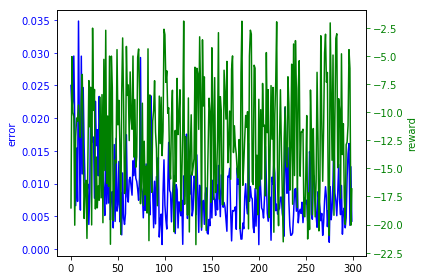

In [10]:

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
ax1.plot([e[1] for e in results], 'b-')
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('error', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot([e[2] for e in results], 'g')
ax2.set_ylabel('reward', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.show()


In [13]:
print('''Behavarial cloning for {}.
Expert  policy mean reward {:.2f} and std {:.3f}.
Learned policy mean reward {:.2f} and std {:.3f}.'''.format(
    envname, 
    np.mean([e[0] for e in results][-100:]),
    np.std([e[0] for e in results][-100:]),
    np.mean([e[2] for e in results][-100:]),
    np.std([e[2] for e in results][-100:])
))

Behavarial cloning for Reacher-v1.
Expert  policy mean reward -4.03 and std 1.261.
Learned policy mean reward -12.21 and std 5.362.


In [21]:
args = pd.Series({
        'expert_policy_file':'experts/' + envname + '.pkl',
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':1,
        'render': True
    })
#learn_imitatation_learning(ffn, args)
evaluate_imitation_learning(ffn, args)

[2017-11-02 23:58:28,885] Making new env: Reacher-v1


[-14.422548584982106]